In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string
import pandas as pd

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
axis_font = {'size':'14'}

In [2]:
def generatingnetlist(filename,ns,length,Ic,n,Rc,Rcu,Imax): # Inputs
    
    # Printing the labels of the elements to read current for this case
    Labels = ['Index','i-sweep']
    
    # Voltage on top
    for i in range(ns):
        #Labels.append(f'v({1+i+ns},{2+i+ns})')
        Labels.append(f'v({1+i+ns})-v({2+i+ns})')
    # Voltage on hts layer
    for i in range(ns):
        if i<ns-1:
            Labels.append(f'v({1+i})-v({2+i})')
        else:
            Labels.append(f'v({1+i})')
    
    # Currents
    for i in range(ns):
        Labels.append(f'@b_{i+1}[i]')
    for i in range(ns+1):
        Labels.append(f'@rc_{i+1}[i]')
    for i in range(ns):
        Labels.append(f'@rcu_{i+1}[i]')

    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    
    #print(probe)
    
    # Constant Parameters for the model
    
    #n = 30 # n-value
    Ec = 100E-6 # Electric field criterion
    #length = 1 # [m] length of tape
    Vc = Ec*length # Voltage criterion
    #Imax = 250 # Maximum current
    
    step = 1 # Step current
    Data_points = int(Imax/step + 1) # Data points calculated directly 
    
    # Start writing netlist
    with open(filename, 'w') as output:
        output.write(f'* Netlist for coating experiment\n')
        output.write('I1 0 1 100\n') # Current source DC
        #output.write(f'I1 0 1 PULSE(0 {Imax} 0 20 20 20)\n') # Pulse I_start I_max t_delay t_rise t_fall t_on
        
        # Voltage sources
        for i in range(ns):
            if i<ns-1:
                output.write(f'b_{i+1} {1+i} {2+i} V={Vc/ns}*pow((I(b_{i+1})/{Ic[i]}),{n[i]})\n')
            else:
                output.write(f'b_{i+1} {1+i} 0 V={Vc/ns}*pow((I(b_{i+1})/{Ic[i]}),{n[i]})\n')
        
        # Contact resistances
        for i in range(ns+1):
            if i<ns:
                output.write(f'rc_{i+1} {1+i} {1+i+ns} {Rc[i]}\n')
            else:
                output.write(f'rc_{i+1} 0 {1+i+ns} {Rc[i]}\n')
       
        # Cu resistances
        for i in range(ns):
            output.write(f'rcu_{i+1} {1+i+ns} {2+i+ns} {Rcu}\n')
    
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} {step}\n')
        output.write('.print dc '+probe+'\n')
        output.write('.end\n')
    return Labels,Data_points
        
    

In [3]:
# This definition is used to run the netlist in ngspice and load the data generated by the program. 

def readdata(filename,Labels,Data_points):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)
    data = np.zeros ([Data_points, len(Labels)])
    
    flag = False
    for line in src:
        #print line
        # Here we initialize the ngspice data array
        '''
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)
        '''
        
        
        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            flag = True
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len(temp_list)
            #print('n_columns\n',n_columns)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if flag == True: # Only if the first index has passed for the ac analysis
            if line[0].isdigit():
                temp_data = [float(x) for x in line.split()]

                for c in range(n_columns):
                    r = fill[c]
                    #print(r, index [c])

                    data [r][index[c]] = temp_data [c]

                    fill [c] = fill [c] + 1
                    if fill [c] == Data_points:
                        fill [c] = 0
    return data

Ic [95.13 95.13 95.13 95.13 95.13 95.13 95.13 95.13 95.13 95.13 95.13 95.13]
n [32.45 32.45 32.45 32.45 32.45 32.45 32.45 32.45 32.45 32.45 32.45 32.45]
Imax = 113


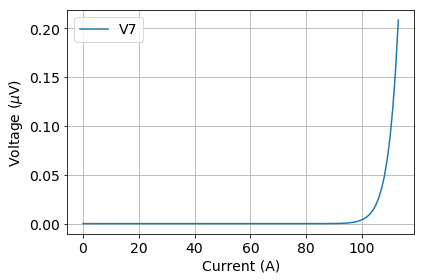

In [4]:
# Here we define all the inputs that are needed to generate the netlist
#%matplotlib notebook

filename = 'coatingexp.cir'
ns = 12

n1 = 32.45 # n-value
length = 0.072 # [m] length of tape

Rcont = 555E-6 # [Ohms] Resistance contact
Rvo = 0.0625 # [Ohms] Resistance VOx film
Rcu = 4E-6 # [Ohms] Resistance Cu strip

Ic_mean = 95.13 # [Amps]

Ic = np.zeros((ns))+Ic_mean
print('Ic',Ic)

n = np.zeros((ns))+n1
print('n',n)

#Imax = Ic_mean*1.25
Imax = 113
print(f'Imax = {Imax}')

Rc = np.zeros((ns+1))+2*Rcont+Rvo


# Generating netlist
Labels,Data_points = generatingnetlist(filename,ns,length,Ic,n,Rc,Rcu,Imax)

# Running ngspice and saving data to notebook
data = readdata(filename,Labels,Data_points)
plt.plot(data[:,1],data[:,2+6]/1E-6,label='V7')
    
plt.xlabel('Current (A)',**axis_font)
plt.ylabel('Voltage ($\mu$V)',**axis_font)
#plt.xlim(-0.1,0.3)
plt.legend(labelspacing=0.001,ncol=1,loc='best',prop={'size': 14})
plt.tight_layout()
plt.grid()
plt.savefig('Ovecurrent_exp.png',dpi=300)